In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from prophet import Prophet


# Serie de tiempo para Gasolina Regular

## Importacion

### A. inicio, fin y frecuencia

In [3]:
# Carga de datos y serie univariante
df_imp = pd.read_csv('./data/importacion.csv', parse_dates=['Fecha'], dayfirst=True)
df_imp.set_index('Fecha', inplace=True)
ts_imp_reg = df_imp['Gasolina regular']

# Inicio, fin y frecuencia
print("Inicio:", ts_imp_reg.index.min())
print("Fin:   ", ts_imp_reg.index.max())
print("Frecuencia inferida:", pd.infer_freq(ts_imp_reg.index))

Inicio: 2001-01-01 00:00:00
Fin:    2024-01-12 00:00:00
Frecuencia inferida: None


### B. Grafico de la serie 

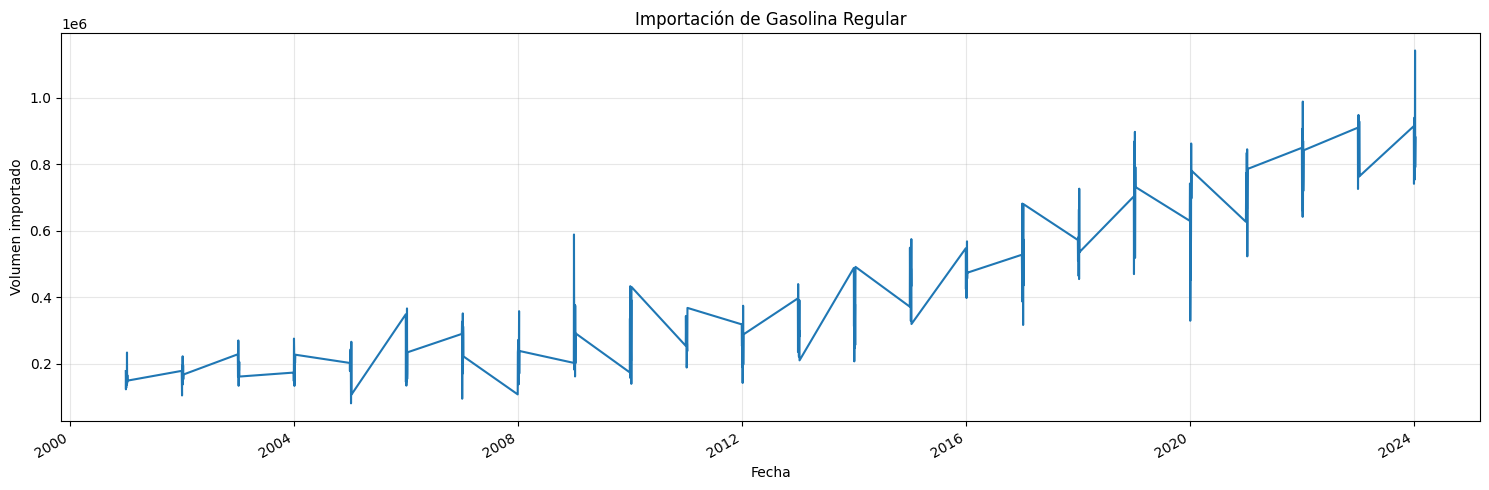

In [5]:
plt.figure(figsize=(15,5))
ts_imp_reg.plot()
plt.title('Importación de Gasolina Regular')
plt.xlabel('Fecha')
plt.ylabel('Volumen importado')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### C. Descomposición de la serie y discusión de estacionariedad

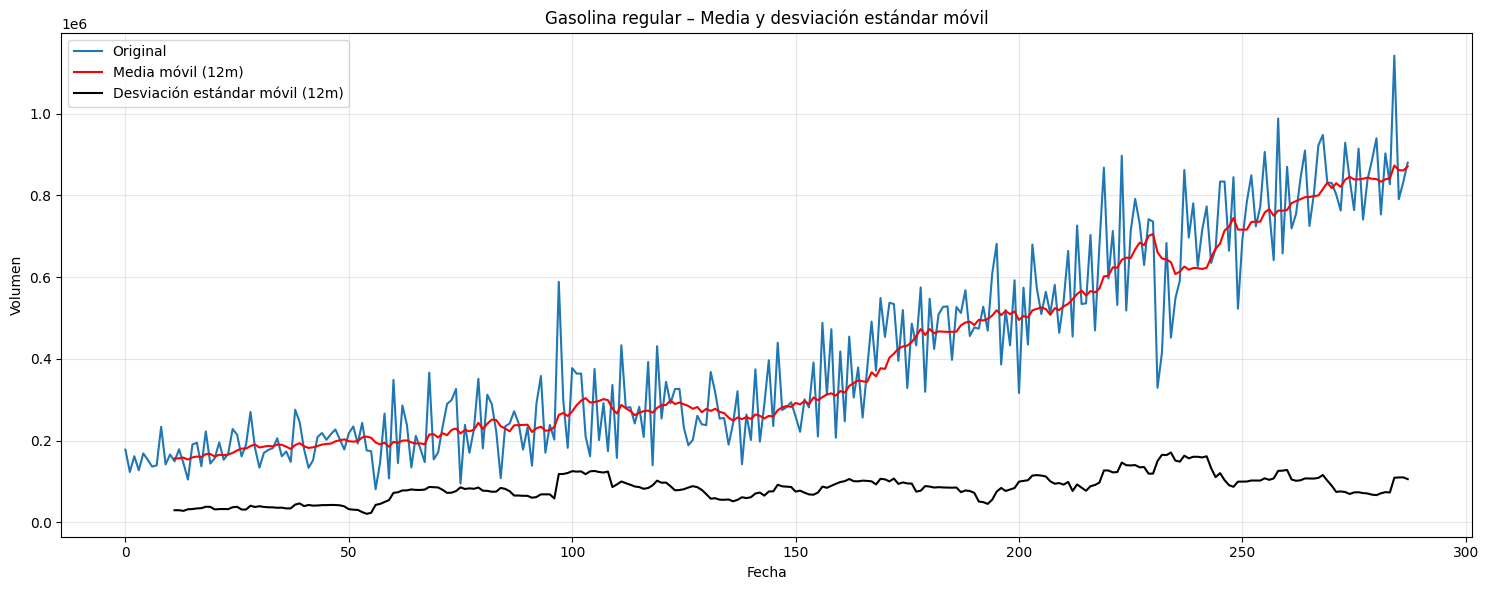 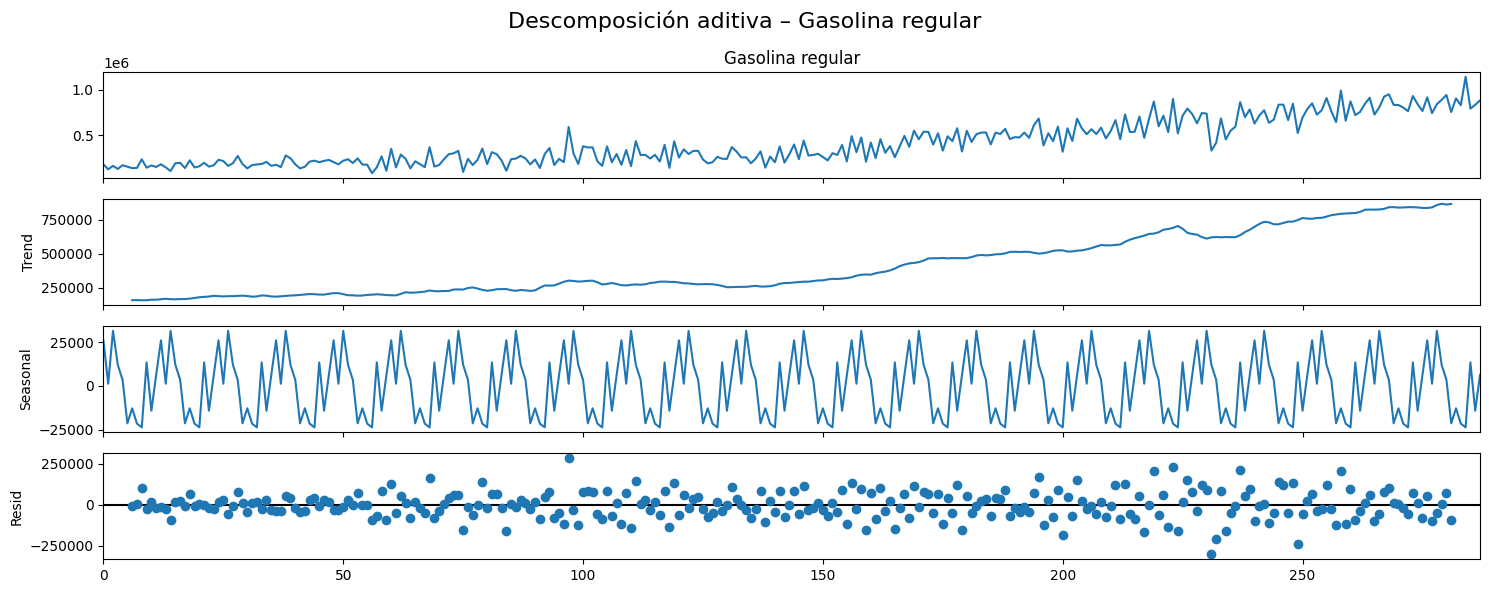

1. Tendencia (media móvil y componente trend)

    - La línea de media móvil (roja) crece de manera clara y sostenida a lo largo de toda la serie.

    - El componente Trend de la descomposición muestra un comportamiento muy similar: arranca en niveles bajos y sube constantemente hasta los valores máximos recientes.

    - La media no es constante: existe una fuerte tendencia alcista, por lo que la serie no es estacionaria en la media.

2. Estacionalidad (componente seasonal)

    - El patrón estacional repite un pico y un valle cada 12 meses, con picos anuales más pronunciados en ciertos periodos.

    - La forma de la estacionalidad es bastante consistente en toda la serie, lo cual indica un ciclo bien definido.

3. Varianza (desviación estándar móvil y residuos)

    - La desviación estándar móvil (negra) aumenta conforme avanza el tiempo: antes era pequeña, y en los últimos años crece hasta niveles muy altos.

    - En el gráfico de residuos (Resid), la dispersión alrededor de cero es pequeña al inicio y se vuelve mucho más amplia hacia el final.

    - La varianza no es constante: al crecer la amplitud de las fluctuaciones, la serie no es estacionaria en la varianza.


*Conclusiones*
- La serie muestra una tendencia claramente ascendente (tanto la media móvil como el componente Trend crecen de manera sostenida).

- Existe un patrón estacional anual definido.

- La varianza no es constante (crece/decrece con el tiempo).

- Por lo tanto, la serie de importación de gasolina regular tiene tendencia y no es estacionaria ni en media ni en varianza.

POR LO CUAL, SE UTILIZARA EL MODELO ARIMA PARA PREDECIR



### D. Determinar si es necesaria una transformación

In [6]:
# Serie original
ts = ts_imp_reg.copy()

# 1. Log–transformación
ts_log = np.log(ts)

# 2. Cálculo de desviaciones estándar móviles (12 meses)
roll_std_orig = ts.rolling(window=12).std()
roll_std_log  = ts_log.rolling(window=12).std()

# 3. Comparar estadísticas de la varianza móvil
print("=== Desviación estándar móvil (original) ===")
print(roll_std_orig.describe())

print("\n=== Desviación estándar móvil (log-transformada) ===")
print(roll_std_log.describe())

=== Desviación estándar móvil (original) ===
count       277.000000
mean      83721.128408
std       31867.364328
min       20821.146522
25%       65545.837019
50%       84223.769790
75%      102087.843972
max      170778.741380
Name: Gasolina regular, dtype: float64

=== Desviación estándar móvil (log-transformada) ===
count    277.000000
mean       0.241621
std        0.092188
min        0.079287
25%        0.173346
50%        0.218814
75%        0.309896
max        0.432560
Name: Gasolina regular, dtype: float64


La desviación estándar móvil original va de ~20 800 a ~170 800, mientras que tras el log pasa a ~0.08–0.43. Por tanto, sí es necesaria la transformación logarítmica para estabilizar la varianza.

### f. Elección de parámetros p, d, q y ajuste de un modelo ARIMA

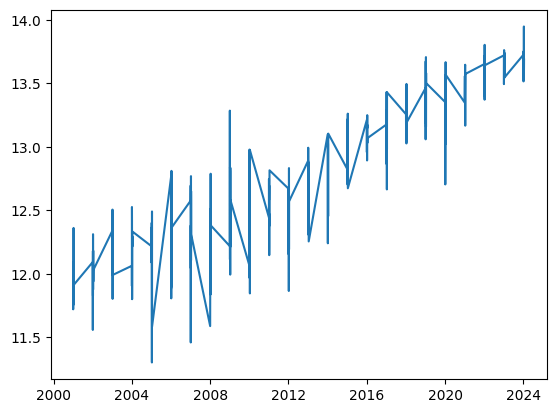

In [11]:
ts_regular = np.log(ts_imp_reg)
plt.plot(ts_regular)

In [12]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_regular, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -0.117925
p-value                        0.947624
# de retardos usados          13.000000
# de observaciones usadas    274.000000
Critical Value (1%)           -3.454444
Critical Value (5%)           -2.872147
Critical Value (10%)          -2.572422
dtype: float64


In [13]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_regular_diff = ts_regular.diff()
ts_regular_diff.dropna(inplace=True)
dfTest = adfuller(ts_regular_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -7.860881e+00
p-value                      5.288333e-12
# de retardos usados         1.200000e+01
# de observaciones usadas    2.740000e+02
Critical Value (1%)         -3.454444e+00
Critical Value (5%)         -2.872147e+00
Critical Value (10%)        -2.572422e+00
dtype: float64


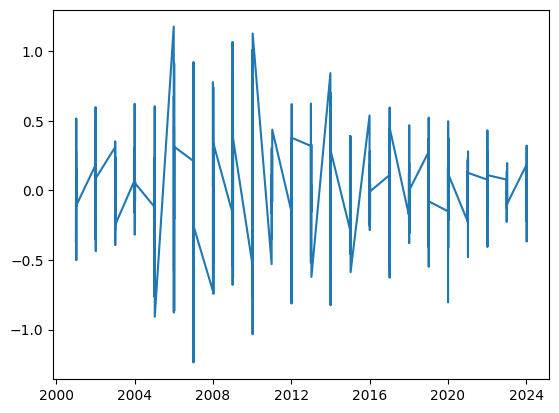

In [17]:
plt.plot(ts_regular_diff)

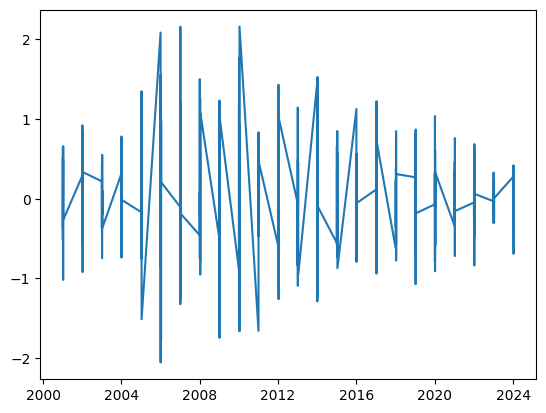

In [16]:
plt.plot(ts_regular.diff().diff())

In [18]:
ts_regular_diff = ts_regular.diff().diff()
ts_regular_diff.dropna(inplace = True)
tsa_acf = acf(ts_regular_diff,nlags=5,fft=False)
tsa_pacf = pacf(ts_regular_diff, nlags=36)
tsa_acf

array([ 1.        , -0.76401793,  0.37685154, -0.17205093,  0.0659215 ,
        0.01482466])

In [19]:
tsa_pacf

array([ 1.        , -0.7666987 , -0.50542228, -0.40195874, -0.42540604,
       -0.36754443, -0.15983775, -0.30594988, -0.23100932, -0.3345867 ,
       -0.45495889, -0.77379799, -2.37370063,  1.76371276,  0.64786855,
        0.40289308,  0.30846854,  0.49386353,  0.47655554,  0.50471635,
        0.92931379, 12.01341385, -1.09081783, -0.53368654, -0.38498268,
       -0.41090759, -0.39739185, -0.46737208, -0.56239493, -1.38335346,
        3.06550771,  0.74252665,  0.46005494,  0.52424823,  0.12975694,
        0.31789544,  0.26619863])

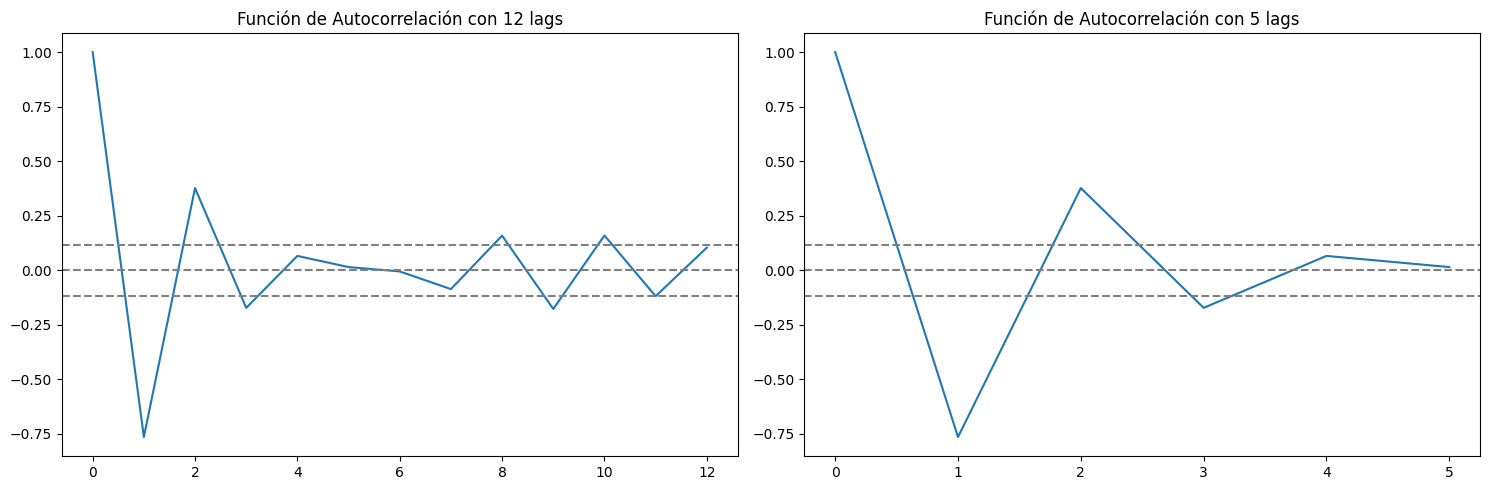

In [20]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_regular_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_regular_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_regular_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 lags')

plt.subplot(122) 
plt.plot(acf(ts_regular_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_regular_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_regular_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 lags')

plt.tight_layout()

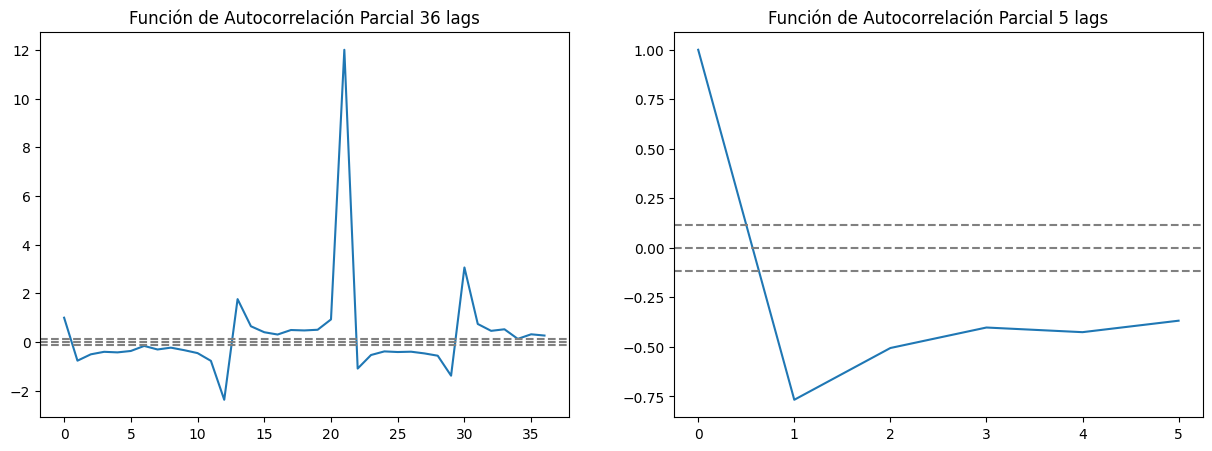

In [21]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_regular_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_regular_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_regular_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 lags')

plt.subplot(122)
plt.plot(pacf(ts_regular_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_regular_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_regular_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 lags')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Según la tabla de corte/decadencia y las cuatro gráficas:

- ACF (lags 0–12 y 0–5): decae gradualmente, no corta en un lag q fijo → no es MA(p).
- PACF (lags 0–36 y 0–5): también decae gradualmente, sin un corte claro en p → no es AR(p).
- Ambas funciones decaen de manera suave → sugiere un modelo ARMA(p,q) sobre la serie ya diferenciada.

Como estamos usando una sola diferenciación (d=1) para eliminar la tendencia, el modelo final es
ARIMA(1, 1, 1)

p = 1

d = 1

q = 1

*Orden autoregresivo (p=1)*

- En la PACF de la serie diferenciada aparece un único pico significativo en el lag 1 (≈ –0.76) y luego decae de forma gradual.
- Esa “caída abrupta” después de k=1 es característica de un proceso AR(1).

*Orden de media móvil (q=1)*

- En la ACF de la serie diferenciada se observa un pico inicial significativo en lag 1 (≈ 0.37) y luego la autocorrelación se anula o cae rápidamente.

In [25]:
from statsmodels.tsa.arima.model import ARIMA

modelo = ARIMA(ts_regular, order=(1, 1, 1))
resultado = modelo.fit()

print(resultado.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2539      0.059     -4.287      0.000      -0.370      -0.138
ma.L1         -0.8268      0.035    -23.941      0.000      -0.894      -0.759
sigma2         0.0677      0.005     14.159      0.000       0.058       0.077


c:\Users\thiag\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thiag\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thiag\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Los coeficientes AR(1) y MA(1) son ambos significativamente distintos de cero (p<0.001), con valores de −0.254 y −0.827 respectivamente, lo que indica que la serie diferenciada presenta un efecto de reversión en un paso (lag 1). La varianza del ruido (σ²≈0.0677) es relativamente baja, sugiriendo un ajuste sólido del modelo ARIMA(1,1,1).

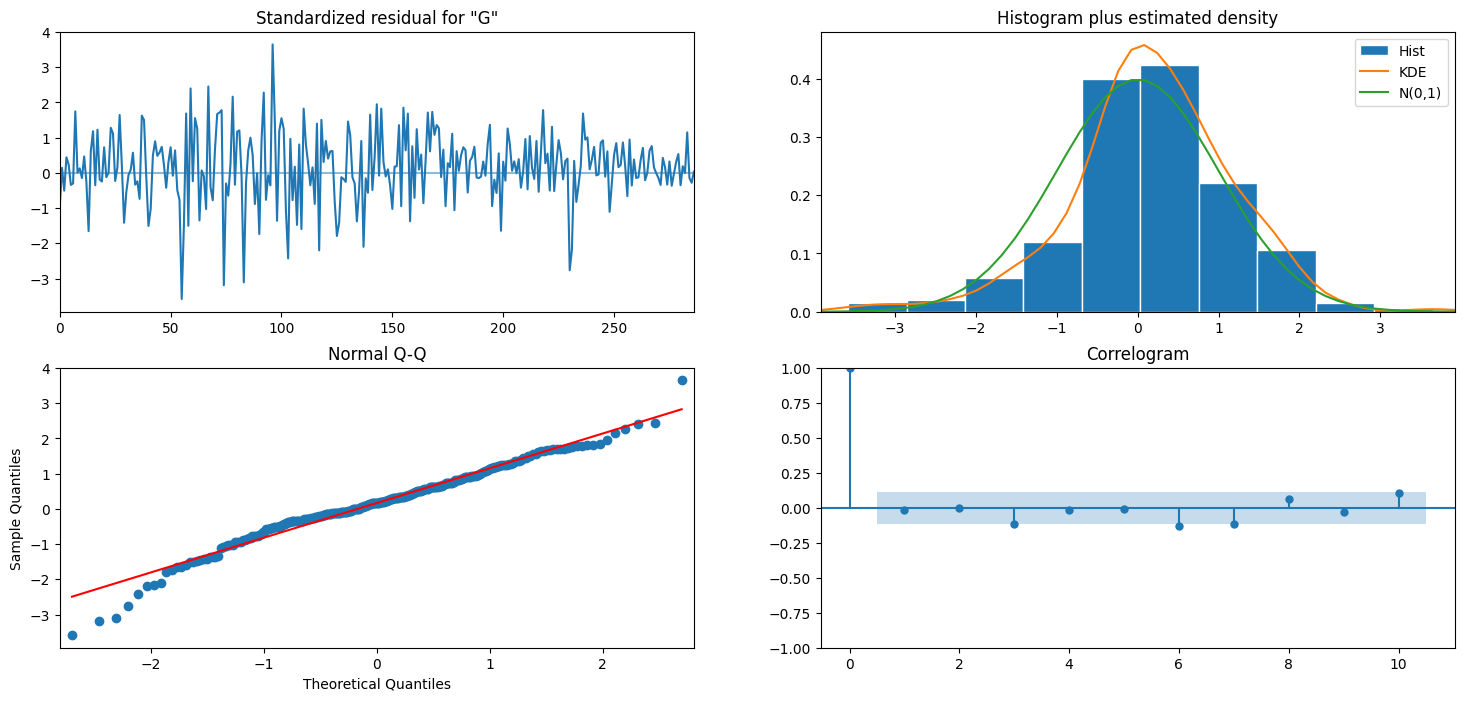

In [26]:
resultado.plot_diagnostics(figsize=(18, 8))
plt.show()

- Distribución casi normal con colas algo gruesas.
- Media ≈ 0 y varianza constante.
- Autocorrelaciones todas dentro de las bandas (ruido blanco).

### G. Varios Modelos de Arima

In [28]:
orders = [
    (0, 1, 1),
    (1, 1, 0),
    (1, 1, 1),
    (2, 1, 1),
    (1, 1, 2)
]

results = []
for order in orders:
    model = ARIMA(ts_regular, order=order)
    res = model.fit()
    print(f"ARIMA{order} → AIC: {res.aic:.2f}")
    results.append((order, res.aic))

best_order, best_aic = min(results, key=lambda x: x[1])
print(f"\nMejor modelo: ARIMA{best_order} con AIC = {best_aic:.2f}")

c:\Users\thiag\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thiag\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thiag\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thiag\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pro

ARIMA(0, 1, 1) → AIC: 63.10
ARIMA(1, 1, 0) → AIC: 128.25
ARIMA(1, 1, 1) → AIC: 49.28
ARIMA(2, 1, 1) → AIC: 50.37
ARIMA(1, 1, 2) → AIC: 49.87

Mejor modelo: ARIMA(1, 1, 1) con AIC = 49.28


El mejor modelo elegido fue el qeu anteriormente habiamos hecho porque con 49.28 supera a todos los demás candidatos (por ejemplo ARIMA(2,1,1) = 50.37, ARIMA(1,1,2) = 49.87), añade solo dos parámetros dinámicos (un AR y un MA), equilibrando bien ajuste y complejidad, el corte en lag 1 en PACF y ACF respalda exactamente un p=1 y q=1.

In [49]:
from statsmodels.tsa.arima.model import ARIMA

df_monthly = (
    df_imp
    .set_index('ds')['y']
    .resample('M').sum()
    .reset_index()
)

# 2. Entrenamiento/test
train_df = df_monthly.iloc[:-12].copy()
test_df  = df_monthly.iloc[-12:].copy()

# --- Prophet: sólo RMSE ---
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(train_df)
future   = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)
pred_prophet = (
    forecast[['ds','yhat']]
    .merge(test_df[['ds','y']], on='ds', how='right')
    .sort_values('ds')
)
rmse_prophet = sqrt(np.mean((pred_prophet['y'] - pred_prophet['yhat'])**2))

# --- ARIMA: evaluar varios (p,d,q) ---
ts = df_monthly.set_index('ds')['y'].asfreq('M')
train_ts = ts.iloc[:-12]
test_ts  = ts.iloc[-12:]

orders = [(0,1,1), (1,1,0), (1,1,1), (2,1,1), (1,1,2)]
results = []

for order in orders:
    model = ARIMA(train_ts, order=order)
    res   = model.fit()
    # forecast 12 meses
    y_pred = res.get_forecast(steps=12).predicted_mean
    # RMSE
    rmse = sqrt(np.mean((test_ts.values - y_pred.values)**2))
    results.append({
        'order': order,
        'AIC':    res.aic,
        'RMSE':   rmse
    })

# 3. Mostrar comparación
df_results = pd.DataFrame(results)
print(df_results)
print(f"\nRMSE Prophet: {rmse_prophet:.2f}")

C:\Users\thiag\AppData\Local\Temp\ipykernel_26900\3460190580.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').sum()
13:16:22 - cmdstanpy - INFO - Chain [1] start processing
13:16:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\thiag\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
C:\Users\thiag\AppData\Local\Temp\ipykernel_26900\3460190580.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df_monthly.set_index('ds')['y'].asfreq('M')


       order          AIC          RMSE
0  (0, 1, 1)  8282.747879  2.893384e+06
1  (1, 1, 0)  8381.815202  6.441533e+06
2  (1, 1, 1)  8283.484969  2.887914e+06
3  (2, 1, 1)  8284.016821  2.883605e+06
4  (1, 1, 2)  8269.750023  2.773237e+06

RMSE Prophet: 1564988.24


Entre los ARIMA evaluados, el modelo ARIMA(1,1,2) obtuvo el menor AIC (≈ 8269.75) y el RMSE más bajo dentro de esa familia (~ 2.77×10⁶).
Sin embargo, el modelo Prophet presenta un RMSE aún menor (~ 1.56×10⁶), casi la mitad del error del mejor ARIMA.
Por tanto, para pronosticar la importación de gasolina regular, Prophet supera claramente a los ARIMA probados, aunque de los ARIMA el más competitivo fue el (1,1,2).